In [1]:
%%time

import json
reviews = []
with open("yelp_academic_dataset_review.json") as f:
    for line in f:
        reviews.append(json.loads(line))

CPU times: user 39.8 s, sys: 4.75 s, total: 44.5 s
Wall time: 44 s


In [2]:
print(reviews[0])

{'stars': 5, 'funny': 0, 'useful': 0, 'review_id': 'NxL8SIC5yqOdnlXCg18IBg', 'business_id': '2aFiy99vNLklCx3T_tGS9A', 'user_id': 'KpkOkG6RIf4Ra25Lhhxf1A', 'type': 'review', 'text': "If you enjoy service by someone who is as competent as he is personable, I would recommend Corey Kaplan highly. The time he has spent here has been very productive and working with him educational and enjoyable. I hope not to need him again (though this is highly unlikely) but knowing he is there if I do is very nice. By the way, I'm not from El Centro, CA. but Scottsdale, AZ.", 'date': '2011-10-10', 'cool': 0}


In [126]:
from collections import Counter
prolific_reviewers = Counter([review['user_id'] for review in reviews]).most_common(30)

In [127]:
keep_ids = {pr[0] : 0 for pr in prolific_reviewers}

In [128]:
by_author = {} # author : "review 1\n review 2\n review 3"
for review in reviews:
    uid = review['user_id']
    if uid in keep_ids:
        uid = review['user_id']
        if uid in by_author:
            by_author[uid] += "\n{}".format(review['text'])
        else:
            by_author[uid] = "{}".format(review['text'])


In [129]:
len(by_author)

30

In [130]:
# check that we have at least 200000 characters for each author
sorted([(len(by_author[key]), key) for key in by_author])[:5]

[(276136, 'ffPY_bHX8vLebHu8LBEqfg'),
 (278427, 'PeLGa5vUR8_mcsn-fn42Jg'),
 (351311, 'cMEtAiW60I5wE_vLfTxoJQ'),
 (370129, 'iDlkZO2iILS8Jwfdy7DP9A'),
 (461333, 'dt9IHwfuZs9D9LOH7gjNew')]

In [132]:
def get_chunks(l, n):
    n = max(1, n)
    return [l[i:i+n] for i in range(0, len(l), n)]

In [133]:
train_texts = []  # the first 100 000 chars from each author
train_labels = [] # each author
test_texts = []   # 100 texts of 1000 characters each (second 100 000 chars of each author)
test_labels = []  # each author * 100

author_int = {author: i for i,author in enumerate(by_author)}
int_author = {author_int[author]: author for author in author_int}

for author in by_author:
    train_text = by_author[author][:50000]
    train_label = author_int[author]
    train_texts.append(train_text)
    train_labels.append(train_label)
    
    short_texts = get_chunks(by_author[author][50000:100000], 1000)
    for text in short_texts:
        test_texts.append(text)
        test_labels.append(author_int[author])

In [134]:
print(len(train_texts), len(test_texts))

30 1500


In [135]:
len(train_texts[0])

50000

In [352]:
# vectorization - chars to ints
import string
import random
import sys

import numpy as np

from keras.models import load_model

def sample(preds, temperature=1.0):
    """Sample predictions from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-6) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate(model, diversity=0.5, text=""):
    """Generate text from a model"""
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(5000):
        x = np.zeros((1, maxlen), dtype=np.int)
        for t, char in enumerate(sentence):
            try:
                x[0, t] = char_indices[char]
            except:
                print(sentence)
        preds = model.predict(x, verbose=0)[0][0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

def vectorize(text):
    """Convert text into character sequences"""
    step = 3
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    X = np.zeros((len(sentences), maxlen), dtype=np.int)
    y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            X[i, t] = char_indices[char]
        y[i, char_indices[next_chars[i]]] = 1
    return X, y

def clean_text(text, charset):
    text = " ".join(text.split())  # all white space is one space
    text = "".join([x for x in text if x in charset])  # remove characters that we don't care about
    return text

def get_model(modelfile, freeze=False):
    model = load_model(modelfile)
    if freeze:
        for layer in model.layers[:6]:
            layer.trainable = False
    return model

chars = " " + string.ascii_letters + string.punctuation  # sorted to keep indices consistent
charset = set(chars)  # for lookup
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maxlen = 100  # must match length which generated model - the sequence length

# load a pretrained language model
modelfile = "charlm2/model_middlemarch_cnn.hdf5"

In [380]:
# test train an author specific model
test_author_text = clean_text(train_texts[0], charset)
test_author_model = get_model(modelfile, freeze=True)
X, y = vectorize(test_author_text)

In [387]:
test_author_model = get_model(modelfile, freeze=True)
test_author_model.compile(loss="categorical_crossentropy", optimizer="adam", loss_weights=[1., 0.2])
test_author_model.fit(X, [y, y], epochs=10, batch_size=128, validation_split=0.1)

Train on 14929 samples, validate on 1659 samples
Epoch 1/10
14929/14929 [==============================] - 24s - loss: 2.4266 - main_out_loss: 1.9901 - aux_out_loss: 2.1820 - val_loss: 2.1216 - val_main_out_loss: 1.7226 - val_aux_out_loss: 1.9947
Epoch 2/10
14929/14929 [==============================] - 10s - loss: 1.9163 - main_out_loss: 1.4955 - aux_out_loss: 2.1040 - val_loss: 2.0452 - val_main_out_loss: 1.6527 - val_aux_out_loss: 1.9626
Epoch 3/10
14929/14929 [==============================] - 10s - loss: 1.6984 - main_out_loss: 1.2871 - aux_out_loss: 2.0563 - val_loss: 2.0439 - val_main_out_loss: 1.6540 - val_aux_out_loss: 1.9493
Epoch 4/10
14929/14929 [==============================] - 10s - loss: 1.5484 - main_out_loss: 1.1430 - aux_out_loss: 2.0268 - val_loss: 2.0482 - val_main_out_loss: 1.6605 - val_aux_out_loss: 1.9385
Epoch 5/10
14929/14929 [==============================] - 10s - loss: 1.4167 - main_out_loss: 1.0163 - aux_out_loss: 2.0018 - val_loss: 2.0876 - val_main_out_l

In [388]:
test_author_model = get_model(modelfile, freeze=True)
test_author_model.fit(X, [y, y], epochs=10, batch_size=128, validation_split=0.1)

Train on 14929 samples, validate on 1659 samples
Epoch 1/10
14929/14929 [==============================] - 36s - loss: 2.5179 - main_out_loss: 2.0782 - aux_out_loss: 2.1987 - val_loss: 2.1857 - val_main_out_loss: 1.7821 - val_aux_out_loss: 2.0181
Epoch 2/10
14929/14929 [==============================] - 25s - loss: 2.1684 - main_out_loss: 1.7447 - aux_out_loss: 2.1184 - val_loss: 2.1105 - val_main_out_loss: 1.7126 - val_aux_out_loss: 1.9896
Epoch 3/10
14929/14929 [==============================] - 25s - loss: 1.9924 - main_out_loss: 1.5778 - aux_out_loss: 2.0733 - val_loss: 2.0837 - val_main_out_loss: 1.6885 - val_aux_out_loss: 1.9760
Epoch 4/10
14929/14929 [==============================] - 25s - loss: 1.8622 - main_out_loss: 1.4546 - aux_out_loss: 2.0377 - val_loss: 2.0641 - val_main_out_loss: 1.6719 - val_aux_out_loss: 1.9609
Epoch 5/10
14929/14929 [==============================] - 25s - loss: 1.7702 - main_out_loss: 1.3686 - aux_out_loss: 2.0077 - val_loss: 2.0514 - val_main_out_l

In [386]:
test_author_model.optimizer

In [145]:
from statistics import mean

print(mean(scores[:50]))
print(mean(scores[50:]))

3.80500852288
5.88146182806


In [146]:
len(scores)

100

In [147]:
%matplotlib inline
from matplotlib import pyplot as plt

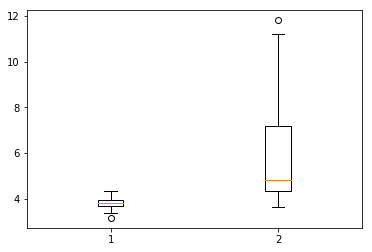

In [149]:
plt.boxplot(get_chunks(scores, 50)[:20]);

In [78]:
scores[:10]

[2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473]

In [189]:
test_labels[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [360]:
generate(test_author_model, diversity=0.7, text="this is some test text does it really matter what it says "*30)

----- Generating with seed: "some test text does it really matter what it says this is some test text does it really matter what "
some test text does it really matter what it says this is some test text does it really matter what I can go be saying the toucest did. I giving a cout before I went here that I will tryink my be and I had abun that I have had a lotakors are their is a countrination has totarchy the supposed this place on proble was pretty and has really knowledge into the house or a werd attentaning and carden  andb anamarh open something and then an ind in the harde that mornings) which was really shakow in the waster to a coufst in the seat fr. especially the schalut and it was not a good deal card)s has been an interroursed with a hat time Will salak was more back their brought and husband but the same go beal action to super it ip another as such suggestions, and round. It wasn't servant to and event, which was tasty and the spinat.. It is the lasticg are so deperse, I

In [180]:
len(train_texts)

30

In [361]:
%%time
author_models = []  # [(author_model, author_id), (author_model, author_id), ...] - ids are ints
for i, train_text in enumerate(train_texts):
    print("{} / {}".format(i, len(train_texts)))
    ct = clean_text(train_text, charset)
    am = get_model(modelfile, freeze=True)
    X, y = vectorize(ct)
    am.fit(X, [y, y], epochs=3, batch_size=128, verbose=False)
    author_models.append((am, train_labels[i]))

0 / 30
1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
CPU times: user 6h 28min 4s, sys: 30min 56s, total: 6h 59min 1s
Wall time: 55min 40s


In [362]:
print(len(author_models))
print(len(test_texts))
print(len(test_labels))

30
1500
1500


In [363]:
word_counts = [text.count(" ") for text in test_texts]
mean(word_counts)

182.57733333333334

In [364]:
# 182 words is quite short
# Try to join 5 tests texts together
longer_test_texts = get_chunks(test_texts, 5)
longer_test_labels = get_chunks(test_labels, 5)

In [365]:
all([len(set(x)) == 1 for x in longer_test_labels])  # Make sure that all combined labels are the same

True

In [366]:
longer_test_texts = ['\n'.join(chunk) for chunk in longer_test_texts]

In [367]:
longer_test_labels = [chunk[0] for chunk in longer_test_labels]

In [368]:
%%time
from random import shuffle
from datetime import datetime

def get_predictions(author_models, test_texts, test_labels):
    """Evaluate each text for each author_model and append first metric to predictions"""
    indicies = list(range(len(test_texts)))

    test_texts = np.array(test_texts)
    test_labels = np.array(test_labels)

    test_texts = test_texts[indicies]
    test_labels = test_labels[indicies]

    predictions = []
    for i, text in enumerate(test_texts):
        t1 = datetime.now()
        print("{} / {}".format(i, len(test_texts)), end=" ")
        X, y = vectorize(clean_text(text, charset))

        losses = []
        for am in author_models:
            print(".", end="")
            model = am[0]
            label = am[1]
            loss = model.evaluate(X, [y, y], verbose=0)
            losses.append((loss[0], label))
        print(" {}".format(datetime.now() - t1))
        predictions.append(losses)
    return predictions
    

predictions_long = get_predictions(author_models, longer_test_texts, longer_test_labels)

0 / 300 .............................. 0:05:31.748432
1 / 300 .............................. 0:00:41.397148
2 / 300 .............................. 0:00:41.535609
3 / 300 .............................. 0:00:41.479349
4 / 300 .............................. 0:00:41.152374
5 / 300 .............................. 0:00:41.341354
6 / 300 .............................. 0:00:41.549168
7 / 300 .............................. 0:00:41.479860
8 / 300 .............................. 0:00:41.368123
9 / 300 .............................. 0:00:41.514281
10 / 300 .............................. 0:00:40.703178
11 / 300 .............................. 0:00:40.389044
12 / 300 .............................. 0:00:40.530118
13 / 300 .............................. 0:00:41.263114
14 / 300 .............................. 0:00:40.575675
15 / 300 .............................. 0:00:40.374385
16 / 300 .............................. 0:00:40.514698
17 / 300 .............................. 0:00:41.142076
18 / 300 ...........

148 / 300 .............................. 0:00:39.522352
149 / 300 .............................. 0:00:38.304991
150 / 300 .............................. 0:00:38.897472
151 / 300 .............................. 0:00:38.679245
152 / 300 .............................. 0:00:38.771781
153 / 300 .............................. 0:00:38.821587
154 / 300 .............................. 0:00:38.741388
155 / 300 .............................. 0:00:38.672861
156 / 300 .............................. 0:00:38.832906
157 / 300 .............................. 0:00:38.827954
158 / 300 .............................. 0:00:38.769065
159 / 300 .............................. 0:00:39.530681
160 / 300 .............................. 0:00:39.006905
161 / 300 .............................. 0:00:39.760114
162 / 300 .............................. 0:00:39.368285
163 / 300 .............................. 0:00:38.947883
164 / 300 .............................. 0:00:38.951897
165 / 300 .............................. 0:00:39

294 / 300 .............................. 0:00:40.019344
295 / 300 .............................. 0:00:40.220888
296 / 300 .............................. 0:00:40.058392
297 / 300 .............................. 0:00:39.858766
298 / 300 .............................. 0:00:39.781350
299 / 300 .............................. 0:00:39.895876
CPU times: user 22h 45min 34s, sys: 2h 10min 9s, total: 1d 55min 43s
Wall time: 3h 29min 40s


In [369]:
len(predictions_long)

300

In [370]:
print("X")

X


In [371]:
pred_is = []
for pred in predictions_long:
    pred_i = [p[0] for p in pred]
    pred_is.append(pred_i)

In [372]:
pred_labs = [np.argmin(pred) for pred in pred_is]

In [373]:
from sklearn.metrics import accuracy_score
accuracy_score(longer_test_labels, pred_labs)

0.83666666666666667

In [123]:
test_author_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 100, 300)      25500       input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100, 300)      0           embedding_1[0][0]                
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 96, 64)        96064       dropout_1[0][0]                  
___________________________________________________________________________________________

In [125]:
test_author_model.evaluatei

<bound method Model.evaluate of <keras.engine.training.Model object at 0x7f7457285b70>>

In [212]:
len(train_texts)

30

In [213]:
len(train_labels)

30

In [227]:
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
word_vec = TfidfVectorizer(min_df=3, ngram_range=(1,2))
char_vec = TfidfVectorizer(min_df=3, ngram_range=(2,5))

fu = FeatureUnion([
    ('word', word_vec),
    ('char', char_vec)
])


X_train = fu.fit_transform(train_texts)

In [232]:
X_test = fu.transform(test_texts)

In [233]:
from sklearn.svm import LinearSVC

svm = LinearSVC()

In [234]:
svm.fit(X_train, train_labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [235]:
preds = svm.predict(X_test)

In [236]:
accuracy_score(test_labels, preds)

0.52200000000000002

In [237]:
X_test_longer = fu.transform(longer_test_texts)

In [238]:
preds = svm.predict(X_test_longer)

In [239]:
accuracy_score(longer_test_labels, preds)

0.92666666666666664

In [261]:
X.shape

(16565, 100)

In [266]:
X, y = vectorize(clean_text(train_texts[3], charset))

In [267]:
X.shape

(16524, 100)

In [268]:
y.shape

(16524, 85)

In [269]:
y[0]

array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False], dtype=bool)

In [270]:
X[0]

array([46,  8,  9, 19,  0,  9, 19,  0, 20,  8,  5,  0,  3, 12, 15, 19,  5,
       19, 20,  0, 19, 13, 15,  7,  0, 19, 16, 15, 20,  0,  6, 15, 18,  0,
       13,  5, 65,  0,  5, 24, 20,  5, 18,  9, 15, 18,  0,  9, 19, 14, 59,
       20,  0,  1, 14, 25, 20,  8,  9, 14,  7,  0,  6,  1, 14,  3, 25, 64,
        0,  1, 14,  4,  0, 14, 15,  0, 15, 14,  5,  0, 23,  1, 19,  0,  8,
        5, 18,  5,  0, 23,  8,  5, 14,  0, 35,  0, 23,  1, 12, 11])

In [336]:
test_author_model.layers[:6]